In [12]:
import torch
import numpy as np
import cv2
import pandas as pd
import os
from functools import partial
import itertools
from collections import defaultdict
from glob import glob

from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Rotate,
    NoOp,
)
import tqdm
from sklearn import metrics
from scipy.optimize import minimize
from scipy.stats import rankdata
from zipfile import ZipFile

import mafat_radar_challenge.data_loader.augmentation as module_aug
import mafat_radar_challenge.data_loader.data_loaders as module_data
import mafat_radar_challenge.model.loss as module_loss
import mafat_radar_challenge.model.metric as module_metric
import mafat_radar_challenge.model.model as module_arch
from mafat_radar_challenge.trainer import Trainer, MAFATTrainer
from mafat_radar_challenge.utils import setup_logger
from mafat_radar_challenge.tester import MAFATTester
import mafat_radar_challenge.data_loader.data_splitter as module_splitter
import mafat_radar_challenge.data_loader.samplers as module_sampler
import mafat_radar_challenge.data_loader.mixers as module_mix

from mafat_radar_challenge.main import get_instance, setup_device
from mafat_radar_challenge.cli import load_config

In [2]:
def predict(model_path, 
            data_path=None, 
            metadata_path=None, 
            tta_transforms=[
                NoOp(p=1),
                HorizontalFlip(p=1),
                VerticalFlip(p=1),
            ]
           ):
    print(model_path)
    # Setup
    cfg = load_config(os.path.join(os.path.dirname(model_path), "config.yml"))
    cfg["augmentation"]["type"] = "ImgAugTTATransform" # TTA Augmentation
    transforms = get_instance(module_aug, "augmentation", cfg)

    cfg["val_data_loader"]["type"] = "MAFATTestDataLoader"
    cfg["val_data_loader"]["args"].pop('shuffle', None)
    if (data_path is not None) and (metadata_path is not None):
        cfg["val_data_loader"]["args"]["batch_size"] = 32
        cfg["val_data_loader"]["args"]["data_dir"] = data_path
        cfg["val_data_loader"]["args"]["csv_dir"] = metadata_path
        
    setattr(transforms, "TRANSFORM_LIST", tta_transforms)
    transforms_list = getattr(transforms, "TRANSFORM_LIST")  # TTA Augmentation
    tta_preds_list = list()  # TTA Augmentation
    
    for idx, transformation in enumerate(transforms_list):
        transforms.CURR_TRANSFORM = transformation
        valid_data_loader = get_instance(module_data, "val_data_loader", cfg, transforms) # Check this
        validation_df = valid_data_loader.dataset.df.copy()
        model = get_instance(module_arch, "arch", cfg)
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint["state_dict"])
        model, device = setup_device(model, cfg["target_devices"])
        model.eval()

        # Predict
        counter = 0
        preds = list()
        with torch.no_grad():
            for idx, data in enumerate(valid_data_loader):
                if isinstance(data, list):
                    for i, _ in enumerate(data):
                        data[i] = data[i].to(device)
                else:
                    data = data.to(device)
                output = model(data).cpu()
                output = torch.sigmoid(output)
                preds.append(output.cpu().numpy())

        preds = np.vstack(preds).reshape(-1).tolist()
        tta_preds_list.append(preds)

    validation_df["score"] = np.mean(tta_preds_list, axis=0)
    return validation_df

def power_average(df_list, weights, axis=0):
    df_final = df_list[0].copy()
    df_final["weighted_score"] = np.mean([df.score**weight for df, weight in zip(df_list, weights)], axis=axis)
    return df_final   

def create_submission(weights, pred_list, aggregation_function):
    final_dfs = [x[0].copy() for x in pred_list]
    groupwise_scores = [np.mean([y.score.values for y in x], axis=0) for x in pred_list]
    for idx, x in enumerate(final_dfs):
        x["score"] = groupwise_scores[idx]
    agg_df = aggregation_function(final_dfs, weights=weights)
    return agg_df

def auc_score(gt, preds):
    fpr, tpr, th = metrics.roc_curve(gt, preds)
    return -metrics.auc(fpr, tpr)

In [3]:
candidate_models_folds = [
[
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_fold0/0922-202644/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_fold1/0923-175040/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_fold2/0923-200711/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_fold3/0923-222449/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_fold4/0924-004209/checkpoints/model_best-swa.pth"   
],

[
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v9_adam_fold0/0925-151207/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v9_adam_fold1/0925-185430/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v9_adam_fold2/0925-223701/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v9_adam_fold3/0926-021930/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v9_adam_fold4/0926-060202/checkpoints/model_best-swa.pth"   
],

[
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_more_aug_v9_adam_centered0/0927-185118/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_more_aug_v9_adam_centered1/0927-210936/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_more_aug_v9_adam_centered2/0927-232928/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_more_aug_v9_adam_centered3/0928-014604/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_more_aug_v9_adam_centered4/0928-040237/checkpoints/model_best.pth"   
],

[
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered0/0928-210739/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered1/0928-232816/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered2/0929-014620/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered3/0929-040430/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered4/0929-062240/checkpoints/model_best-swa.pth"   
],

[
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered_blend0/0929-225220/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered_blend1/0930-011037/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered_blend2/0930-032751/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered_blend3/0930-054506/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered_blend4/0930-080225/checkpoints/model_best.pth"   
],

[
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v9_adam_centered0/0930-213909/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v9_adam_centered1/0930-234106/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v9_adam_centered2/1001-014329/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v9_adam_centered3/1001-034550/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v9_adam_centered4/1001-054814/checkpoints/model_best-swa.pth"   
],

[
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_pw_0.9_fold0/1001-195710/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_pw_0.9_fold1/1001-221433/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_pw_0.9_fold2/1002-003156/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_pw_0.9_fold3/1002-024950/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_pw_0.9_fold4/1002-050747/checkpoints/model_best.pth"   
],

[
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_focal_fold0/1002-072547/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_focal_fold1/1002-094356/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_focal_fold2/1002-120142/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_focal_fold3/1002-141913/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_focal_fold4/1002-163722/checkpoints/model_best.pth"   
],

[
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold0/1003-101910/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold1/1003-175906/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold2/1004-013832/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold3/1004-091304/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold4/1004-164923/checkpoints/model_best.pth"   
],

[
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_pruned_more_aux_more_synth_specaug_simple_aug_v9_adam_centered0/1005-005432/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_pruned_more_aux_more_synth_specaug_simple_aug_v9_adam_centered1/1005-021455/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_pruned_more_aux_more_synth_specaug_simple_aug_v9_adam_centered2/1005-033519/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_pruned_more_aux_more_synth_specaug_simple_aug_v9_adam_centered3/1005-045546/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_pruned_more_aux_more_synth_specaug_simple_aug_v9_adam_centered4/1005-061620/checkpoints/model_best.pth"   
],

[
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold0/1005-184411/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold1/1006-082322/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold2/1006-220329/checkpoints/model_best.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold3/1007-114115/checkpoints/model_best-swa.pth",
    "/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold4/1008-012514/checkpoints/model_best.pth"   
],
]

In [4]:
output_path = "/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one"
# data_paths = ["/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/mafat_private_test_v9_spectrogram.npy"]*len(candidate_models_folds)
data_paths = ["/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/MAFAT RADAR Challenge - Private Test Set V1.pkl"]*len(candidate_models_folds)
metadata_paths = ["/home/agarcia/repos/mafat-radar-challenge/mafat_radar_challenge/data/MAFAT RADAR Challenge - Private Test Set V1.csv"]*len(candidate_models_folds)
group_dfs = list()
for data_path, metadata_path, models in tqdm.tqdm(zip(data_paths, metadata_paths, candidate_models_folds)):
    fold_dfs = list()
    for model in models:
        model_alias = os.path.join(output_path, model.split(os.sep)[-4])
        print(model_alias)
        df = predict(model, data_path, metadata_path)
        df.to_csv(os.path.join(output_path, model_alias) + "-private-test.csv", index=False)  
        fold_dfs.append(df.copy())
    group_dfs.append(fold_dfs)

0it [00:00, ?it/s]

/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_fold0
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_fold0/0922-202644/checkpoints/model_best-swa.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using HorizontalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using VerticalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_fold1
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_fold1/0923-175040/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using HorizontalFlip(alway

1it [00:11, 11.26s/it]

/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v9_adam_fold0
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v9_adam_fold0/0925-151207/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b3
Using HorizontalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b3
Using VerticalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b3
/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v9_adam_fold1
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b3_more_aux_more_synth_specaug_simple_aug_v9_adam_fold1/0925-185430/checkpoints/model_best-swa.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b3
Using HorizontalFlip(alway

2it [00:24, 11.70s/it]

/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_more_aug_v9_adam_centered0
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_more_aug_v9_adam_centered0/0927-185118/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using HorizontalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using VerticalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_more_aug_v9_adam_centered1
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_more_aug_v9_adam_centered1/0927-210936/checkpoints/model_best-swa.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using HorizontalFl

3it [00:33, 11.12s/it]

/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered0
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered0/0928-210739/checkpoints/model_best-swa.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using HorizontalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using VerticalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered1
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered1/0928-232816/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using HorizontalFl

4it [00:43, 10.65s/it]

/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered_blend0
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered_blend0/0929-225220/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using HorizontalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using VerticalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered_blend1
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_less_aug_v9_adam_centered_blend1/0930-011037/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b

5it [00:53, 10.38s/it]

/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v9_adam_centered0
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v9_adam_centered0/0930-213909/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b1
Using HorizontalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b1
Using VerticalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b1
/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v9_adam_centered1
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b1_more_aux_more_synth_specaug_simple_aug_v9_adam_centered1/0930-234106/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b1
Using Horizont

6it [01:02,  9.96s/it]

/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_pw_0.9_fold0
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_pw_0.9_fold0/1001-195710/checkpoints/model_best-swa.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using HorizontalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using VerticalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_pw_0.9_fold1
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_pw_0.9_fold1/1001-221433/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b

7it [01:11,  9.88s/it]

/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_focal_fold0
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_focal_fold0/1002-072547/checkpoints/model_best-swa.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using HorizontalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Using VerticalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_focal_fold1
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_more_aux_more_synth_specaug_simple_aug_v9_adam_focal_fold1/1002-094356/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b2
Us

8it [01:21,  9.91s/it]

/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold0
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold0/1003-101910/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b4
Using HorizontalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b4
Using VerticalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b4
/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold1
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b4_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold1/1003-175906/checkpoints/model_best-swa.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for effici

9it [01:44, 13.67s/it]

/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_pruned_more_aux_more_synth_specaug_simple_aug_v9_adam_centered0
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_pruned_more_aux_more_synth_specaug_simple_aug_v9_adam_centered0/1005-005432/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Using HorizontalFlip(always_apply=False, p=1)
Using VerticalFlip(always_apply=False, p=1)
/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b2_pruned_more_aux_more_synth_specaug_simple_aug_v9_adam_centered1
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b2_pruned_more_aux_more_synth_specaug_simple_aug_v9_adam_centered1/1005-021455/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Using HorizontalFlip(always_apply=False, p=1)
Using VerticalFlip(always_apply=False, p=1)
/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica

10it [01:54, 12.72s/it]

/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold0
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold0/1005-184411/checkpoints/model_best-swa.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b5
Using HorizontalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b5
Using VerticalFlip(always_apply=False, p=1)
Loaded pretrained weights for efficientnet-b5
/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold1
/mnt/agarcia_HDD/mafat-radar-challenge-experiment/MAFAT_replica_aug_eff_b5_more_aux_more_synth_specaug_simple_aug_v9_adam_centered_fold1/1006-082322/checkpoints/model_best.pth
Using NoOp(always_apply=False, p=1)
Loaded pretrained weights for effici

11it [02:32, 13.83s/it]


In [5]:
partial_opt_fun = partial(create_submission, 
                          pred_list=group_dfs, 
                          aggregation_function=power_average)

In [6]:
submission = partial_opt_fun( [ 2.31519945,  6.73733468,  0.92595314, 10.30688081,  2.3743504 ,
       18.62242205, 11.18264359, 25.33587841,  0.0532344 ,  4.96738272,
        8.80459933])
# auc_score(submission.label, submission.weighted_score)

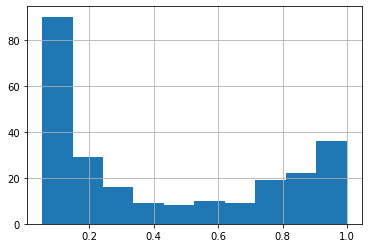

In [7]:
submission.weighted_score.hist()

In [9]:
submission = submission[["segment_id", "weighted_score"]]
submission.columns = ["segment_id", "prediction"]

In [17]:
submission.head()

,segment_id,prediction
0,6940,0.875022
1,6941,0.204544
2,6942,0.058319
3,6943,0.735913
4,6944,0.081505


In [13]:
output_csv = os.path.join(
    "/home/agarcia/repos/mafat-radar-challenge/submissions/ensemble_one", 
    "submission_ensemble_one.csv")
submission.to_csv(output_csv, index=False)
# Download zip file

with ZipFile(os.path.splitext(output_csv)[0] + ".zip", "w") as myzip:
    myzip.write(output_csv, arcname=os.path.basename(output_csv))